In [1]:
import uuid
import os
import time
import cv2

In [3]:
IMAGES_PATH = os.path.join('data1','images1')
number_images = 30

In [ ]:
# from inspect import ismethod


cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
!labelme

In [2]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

In [3]:
# from random import shuffle


images = tf.data.Dataset.list_files('data1\\images1\\*jpg')

In [ ]:
images.as_numpy_iterator().next()

In [5]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [6]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [8]:
image_generator = images.batch(5).as_numpy_iterator()

In [9]:
plot_images = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [4]:
import splitfolders

In [ ]:
input_folder = 'data1/'
splitfolders.ratio(input_folder, output= 'data1/', seed=42,
                    ratio=(.7,.15,.15), group_prefix=None)

In [11]:
import albumentations as alb

In [12]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2),
                        alb.RGBShift(p=0.2),
                        alb.VerticalFlip(p=0.5)],
                        bbox_params = alb.BboxParams(format='albumentations',
                                                    label_fields=['class_labels']))

In [81]:
# import cv2
img = cv2.imread(os.path.join('data1','train','images1','0a6e7fc5-1f7a-11ed-94f0-001a7dda7115.jpg'))

In [82]:
import json
with open(os.path.join('data1','train','labels1','0a6e7fc5-1f7a-11ed-94f0-001a7dda7115.json'),'r') as f:
    label = json.load(f)

In [ ]:
label['shapes'][0]

In [84]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [85]:
coords = list(np.divide(coords, [640, 480,640,480]))

In [ ]:
coords

In [87]:
augmented = augmentor(image=img, bboxes= [coords], class_labels=['face'])

In [ ]:
augmented

In [ ]:
augmented['bboxes'][0][2:]

In [ ]:
cv2.rectangle(augmented['image'],
                tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
                tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
                (255,0,0), 2)

plt.imshow(augmented['image'])

In [95]:
# from __future__ import annotations
# import numpy as np
# import cv2
# import json
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data1', partition, 'images1')):
        img = cv2.imread(os.path.join('data1', partition, 'images1',image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data1','labels1', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path,"r") as f:
                label = json.load(f)
            
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img,bboxes=[coords],class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
        except Exception as e:
            print(e)        

In [ ]:
# for partition in ['train_images','test_images','val_images']:
#     partition = tf.data.Dataset.list_files(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg')

In [ ]:
coords

In [97]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [98]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [99]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

In [101]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf=8") as f:
        label = json.load(f)
    
    return [label['class']], label['bbox']

In [102]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [103]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [104]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

In [ ]:
# for i in [train_images, train_labels, test_images, test_labels, val_images, val_labels]:
#     print(len(i))

In [106]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [107]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [108]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[1]

In [110]:
data_samples = train.as_numpy_iterator()

In [111]:
res = data_samples.next()

In [ ]:
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image, 
                   tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                    tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                    (255,0,0), 2)
        
    ax[idx].imshow(sample_image)

In [113]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16 

In [114]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)
    
    #Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1,activation='sigmoid')(class1)
    
    #Bounding box Model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4,activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [115]:
vgg = VGG16(include_top=False)

In [ ]:
vgg.summary()

In [117]:
facetracker = build_model()

In [ ]:
facetracker.summary()

In [119]:
X, y = train.as_numpy_iterator().next()

In [ ]:
classes, coords = facetracker.predict(X)

In [ ]:
y

In [ ]:
coords

In [135]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [ ]:
lr_decay

In [137]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [138]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [139]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [ ]:
y[1]

In [ ]:
localization_loss(y[1], coords).numpy()

In [ ]:
type(y[1][1][1])

In [ ]:
classloss(y[0], classes)

In [ ]:
regressloss(y[1], coords)

## Train the model

In [159]:
class FaceTracker(Model):
    def __init__(self, facetracker, **kwargs):
        super().__init__(self, **kwargs)
        self.model = facetracker
    
    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X,y = batch
        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5*batch_classloss

            grad = tape.gradient(total_loss,  self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y =batch 

        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [160]:
model = FaceTracker(facetracker)

In [161]:
model.compile(opt, classloss, regressloss)

In [162]:
logdir = 'logs'

In [163]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
hist.history

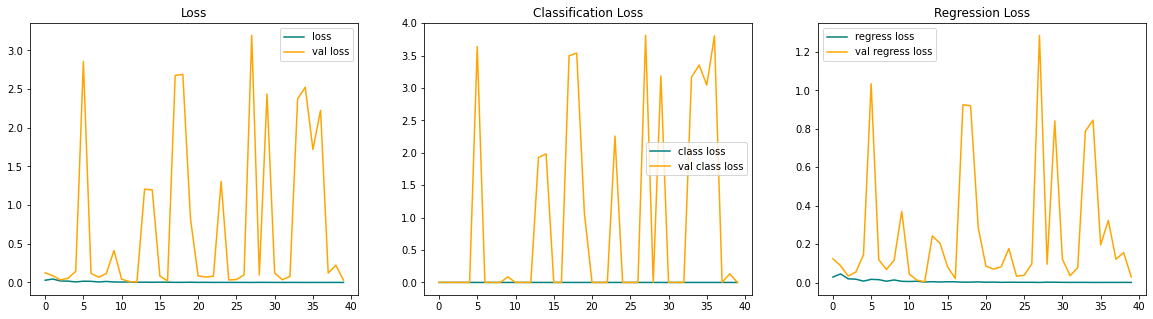

In [196]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [167]:
test_data = test.as_numpy_iterator()

In [189]:
test_sample = test_data.next()

In [190]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 438ms/step


In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [ ]:
from tensorflow.keras.models import load_model
facetracker.save('facetracker.h5')

### REAL TIME

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('FaceTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()